## Lesson 7:
### Exercise 1: The irreducible mass of black holes

In [261]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as scipy
from scipy import stats
from tqdm.notebook import tqdm
from sklearn.mixture import GaussianMixture
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
import seaborn as sns
c1 = sns.color_palette('rocket', 5)
c2 = sns.color_palette('mako', 5)
c3 = sns.color_palette('flare', 5)

plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['font.size'] = 11

Suppose you have repeated measurements of $\chi$ (spin of the black hole) and $M$ (mass of the black hole).

**Set $\mu = 1$ in the code: remember that all the masses will be measured in units of $\mu$**

We can then compute the irreducible mass of the black hole and visualize its distribution with an histogram.

$$M_{\rm irr} = M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$$

We can first deal with the optimal bin-width problem by taking into account **"Scott's rule"** and **"Freedman-Diaconis rule"**:

Text(0.5, 0, '$M$')

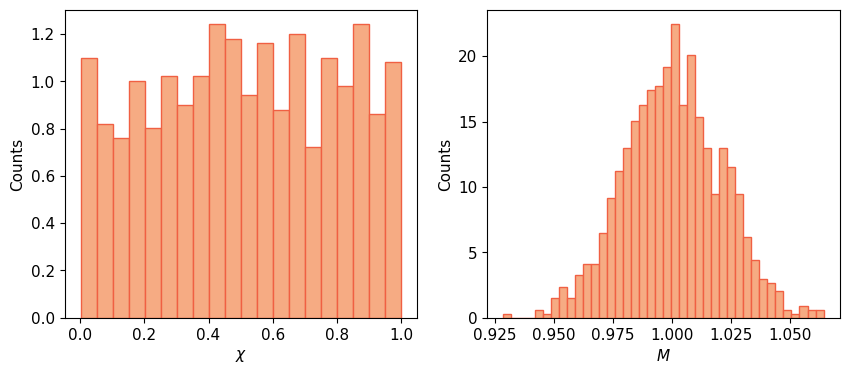

In [336]:
def M_irr (M, chi):
    return M*np.sqrt((1+np.sqrt(1-chi**2))/2)

sigma = 0.02
mu = 1
N = 1000
chi = np.random.uniform(0, 1, N)
M = np.random.normal(mu, sigma, N)

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.subplot(121)
plt.hist(chi, density=True, bins=20, ec=c1[3], fc=c1[4]);
plt.xlabel(r"$\chi$")
plt.ylabel("Counts")
plt.subplot(122)
plt.hist(M, density=True, bins=40, ec=c1[3], fc=c1[4]);
plt.ylabel("Counts")
plt.xlabel(r"$M$")

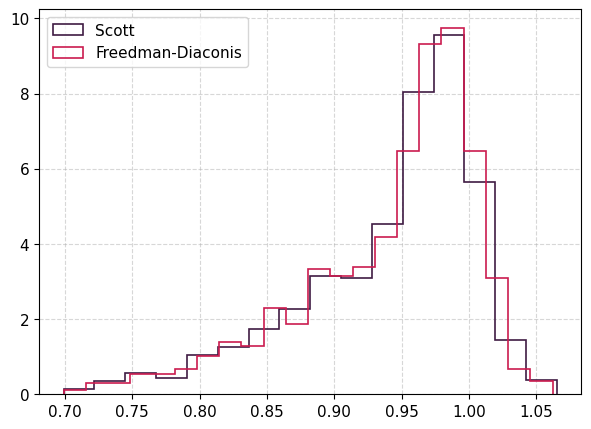

In [337]:
m_irr = M_irr(M, chi)

fig, ax = plt.subplots(figsize=(7,5))
h1 = fancyhist(m_irr, bins="scott", histtype="step", lw = 1.2, density=True, 
               label = 'Scott', color=c1[0])
h2 = fancyhist(m_irr, bins="freedman", histtype="step", lw = 1.2, density=True, 
               label = 'Freedman-Diaconis', color=c1[2])
plt.grid(True, ls='dashed', alpha=0.5)
plt.legend(loc = 'upper left');

---
Let's now plot the $pdf$ of the *irreducible mass* using **Kernel Density Estimation (KDE)**, both with a *top-hat* kernel and a *Gaussian* kernel.

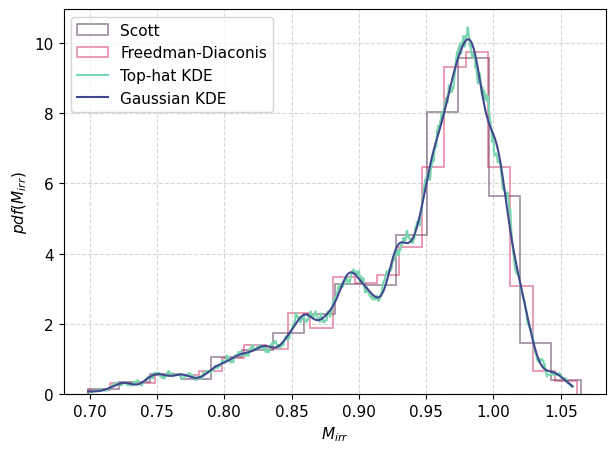

In [338]:
fig, ax = plt.subplots(figsize=(7,5))

m_grid = np.linspace(m_irr.min(), m_irr.max(), 1000)

def kde_sklearn(data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, # this is the generic fit function
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis]) # this is the function fitted to my data
    log_pdf = kde_skl.score_samples(m_grid[:, np.newaxis]) # sklearn returns log(density)
    return np.exp(log_pdf)

PDFtop = kde_sklearn(m_irr, bandwidth=0.01, kernel = 'tophat')
PDFgauss = kde_sklearn(m_irr, bandwidth=0.006, kernel = 'gaussian')

h1 = fancyhist(m_irr, bins="scott", histtype="step", lw = 1.2, density=True, 
               label = 'Scott', color=c1[0], alpha=0.5)
h2 = fancyhist(m_irr, bins="freedman", histtype="step", lw = 1.2, density=True, 
               label = 'Freedman-Diaconis', color=c1[2], alpha=0.5)

plt.plot(m_grid, PDFtop, label = 'Top-hat KDE', c=c2[4])
plt.plot(m_grid, PDFgauss, label = 'Gaussian KDE', c=c2[1])

plt.xlabel(r"$M_{irr}$")
plt.ylabel(r"$pdf(M_{irr})$")
plt.grid(True, ls='dashed', alpha=0.5)
plt.legend();

### KS distance between $M_{irr}$ and $f$ for $\neq$ values of $\sigma$

We're computing the Kolmogorov-Smirnov distance between $M_{irr}$ and $f$ for different values of $\sigma$ (characterising the distribution of black hole masses) in the range $(0.001, 1)$. What do we observe?

$f$ is defined as the ratio between the *irreducible mass* and the initial mass of the black hole:

$$f \equiv \frac{M_{irr}}{M} = \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$$

  0%|          | 0/50 [00:00<?, ?it/s]

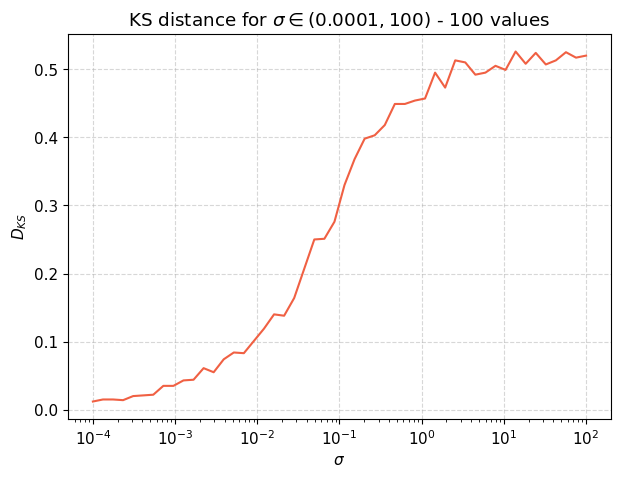

In [339]:
sigma_low = 1e-4
sigma_high = 1e2
ks_dist = []
sigmas = np.logspace(np.log10(sigma_low), np.log10(sigma_high), 50)

for sigma_ in tqdm(sigmas):
    M_sig = np.random.normal(mu, sigma_, N)
    m_irr_sig = M_irr(M_sig, chi)
    
    f_sigma = m_irr_sig/M_sig
    D_KS = stats.ks_2samp(m_irr_sig, f_sigma).statistic
    ks_dist.append(D_KS)
    
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(sigmas, ks_dist, c=c1[3]) 
plt.title(f'KS distance for $\sigma \in (%.4f, %i)$ - 100 values'% (sigma_low, sigma_high))
plt.xlabel('$\sigma$')
plt.ylabel('$D_{KS}$')
plt.xscale('log')
plt.grid(True, ls='dashed', alpha=0.5)
plt.show()

### KS distance between $M_{irr}$ and $M$ for $\neq$ values of $\sigma$


  0%|          | 0/50 [00:00<?, ?it/s]

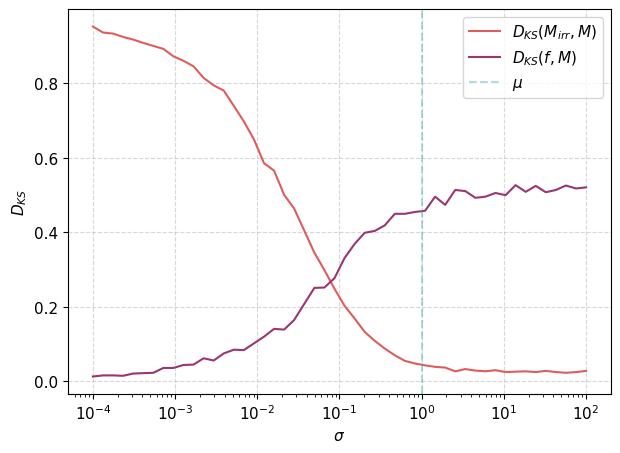

In [340]:
fig, ax = plt.subplots(figsize=(7,5))
ks_dist2 = []

for sigma_ in tqdm(sigmas):
    M_sig = np.random.normal(mu, sigma_, N)
    m_irr_sig = M_irr(M_sig, chi)
    D_KS = stats.ks_2samp(m_irr_sig, M_sig).statistic
    ks_dist2.append(D_KS)

plt.plot(sigmas, ks_dist2, c=c3[1], label=r'$D_{KS}(M_{irr}, M)$')
plt.plot(sigmas, ks_dist, c=c3[3], label=r'$D_{KS}(f, M)$')
plt.xlabel('$\sigma$')
plt.ylabel('$D_{KS}$')
plt.xscale('log')
plt.axvline(mu, ls='dashed', c=c2[3], label=r'$\mu$', alpha=0.4)
plt.legend()
plt.grid(True, ls='dashed', alpha=0.5)
plt.show()

We can clearly notice, from the previous plot, that the **KS** distance between the distribution of $f$ and $M$ tends to $0$ for $\sigma \gg \mu$, while the **KS** distance bewteen $M_{irr}$ and $M$ tends to 0 for $\sigma \ll \mu$. How can we explain this?

- Since $f$ is defined as $f \equiv \frac{M_{irr}}{M}$, $f$ and $M_{irr}$ share the same distribution if $M$ has a fixed value, or a very narrow distribution with respect to the mean value of the black hole mass. That happens when we associate to the black hole mass distribution a delta function centered in the mean, that is when $\sigma \rightarrow 0$.
- Since $M_{\rm irr} = M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$, for the same reasoning, $M_{irr}$ and $M$ are equally distributed if the distribution of $\chi$ is very narrow with respect to the distribution of $M$. The only way to achieve this in the exercise is by sending $\sigma \rightarrow \infty$ (because the width of the uniform distribution of $\chi$ is fixed).

Now we compute $pdf(f)$ analytically. We can use the definition, $f \equiv \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}$, and consider it as a change of variable. We know the distribution of $\chi$ and we want to compute the distribution of $f$.

Recall the formula we studied in *lecture 2*, for a change of variable $y = y(x)$

$$p(y) = \left| \frac{dx}{dy}\right| p(x)$$

In our case $p(x) = p(\chi) = 1$. By manually computing the derivative we get:

$$p(f(\chi)) = - 2\sqrt{2} \left[ \frac{\sqrt{(1+\sqrt{1-\chi^2})(1-\chi^2)}}{\chi} \right] p(\chi)$$

Now we rewrite everything in terms of $f$ and we get:

$$p(f) = \frac{2(2f^2-1)}{\sqrt{1-f^2}}$$


In [341]:
def pdf_f(f):
    return 2*(2*f**2 - 1)/(np.sqrt(1-f**2)) * 1

f = m_irr/M

chi_arr = np.linspace(chi.min(), chi.max(), 1000)
f_array = np.linspace(f.min(), f.max(), 1000)

Then we can compute the *$pdf$* of $M_{irr}$ by using the theorem for the *distribution of the product of two random variables*, since $M_{irr} = f \cdot M$, obtaining:

\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\, \label{pmirr}
\end{equation}

which can be integrated numerically by means of the *scipy.integrate.quad* module.

  0%|          | 0/1000 [00:00<?, ?it/s]

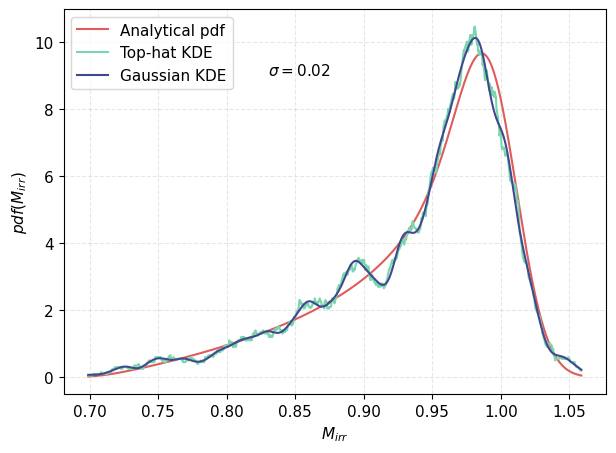

In [342]:
def integral_func(f, m_irr):
    return np.exp(-((m_irr/f - mu)**2)/(2*sigma**2))*(2*f**2 -1)/(f*np.sqrt(1-f**2))

p_m_irr = []
for m_i in tqdm(m_grid):
    integral, error = scipy.integrate.quad(integral_func, 1/np.sqrt(2), 1, args=m_i)
    integral = integral*np.sqrt(2/np.pi)/sigma
    p_m_irr.append(integral)

plt.plot(m_grid, p_m_irr, c=c3[1], label='Analytical pdf')
plt.plot(m_grid, PDFtop, label = 'Top-hat KDE', c=c2[4])
plt.plot(m_grid, PDFgauss, label = 'Gaussian KDE', c=c2[1])

plt.text(0.83, 9, r'$\sigma = %.2f$'%sigma)
plt.grid(True, ls='dashed', alpha=0.3)

plt.xlabel(r"$M_{irr}$")
plt.ylabel(r"$pdf(M_{irr})$")

plt.legend();

By comparing the analytical $pdf$ with those estimated through **KDE**, we can see that they match quite well.